Exploratory Data Analysis for the ratings.csv to check avg ratings, most active rater and data sparsity.

Data loaded
Rows (ratings): 100836
Columns: ['userId', 'movieId', 'rating', 'timestamp']
------------------------------
1. Average rating off all the movies: 3.50
2. Most active user (ID: 414) has given: 2698 ratings
(Average amount of rating given by users: 165)
3. Data sparsity: 98.3000%
Unique users: 610
Unique movies: 9724
------------------------------


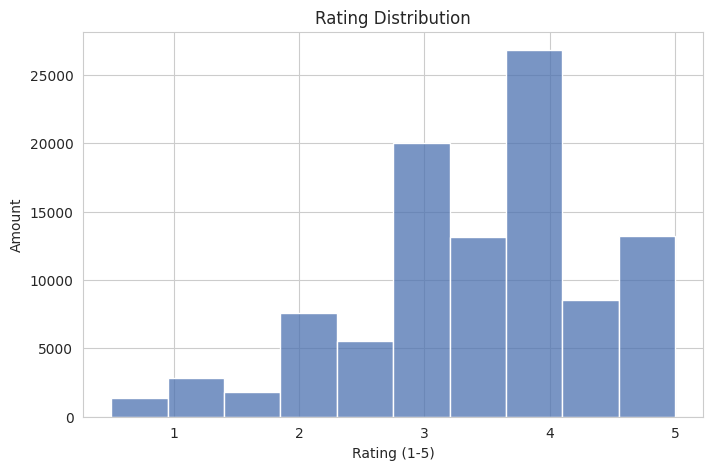

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Exploratory Data Analysis for checking the data

sns.set_style("whitegrid")

try:
    df = pd.read_csv("./data/ratings.csv")
    print("Data loaded")
except FileNotFoundError:
    print("Error: File not found")

print(f"Rows (ratings): {df.shape[0]}")
print(f"Columns: {df.columns.tolist()}")
print("-" * 30)

avg_rating = df['rating'].mean()
print(f"1. Average rating off all the movies: {avg_rating:.2f}")

user_activity = df['userId'].value_counts()
most_active_count = user_activity.max()
most_active_user = user_activity.idxmax()

print(f"2. Most active user (ID: {most_active_user}) has given: {most_active_count} ratings")
print(f"(Average amount of rating given by users: {user_activity.mean():.0f})")

n_users = df['userId'].nunique()
n_movies = df['movieId'].nunique()

total_possible_ratings = n_users * n_movies
actual_ratings = len(df)

sparsity = 1 - (actual_ratings / total_possible_ratings)
sparsity_percent = sparsity * 100

print(f"3. Data sparsity: {sparsity_percent:.4f}%")
print(f"Unique users: {n_users}")
print(f"Unique movies: {n_movies}")

print("-" * 30)


plt.figure(figsize=(8, 5))
sns.histplot(df['rating'], bins=10, kde=False, color='#4c72b0')
plt.title('Rating Distribution')
plt.xlabel('Rating (1-5)')
plt.ylabel('Amount')
plt.show()

We need to vectorize the genre names so that they can run through the model. Then we count the angle between the vectors, if its small aka near 1 the movies are alike. We use linear_kernel for fast compilation becase our dataset is so small. This model doesn't take into consideration the ratings of the movies just the genre, which is why we need to implement collaborative filtering next.

In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


try:
    movies_df = pd.read_csv('./data/movies.csv')
    print(f"Movies loaded. Total amount: {len(movies_df)}")
except FileNotFoundError:
    print("Error: File not found")

movies_df['genres_str'] = movies_df['genres'].str.replace('|', ' ')

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_df['genres_str'])

print(f"TF-IDF matrix size: {tfidf_matrix.shape}")

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

indices = pd.Series(movies_df.index, index=movies_df['title']).drop_duplicates()

def get_content_recommendations(title, cosine_sim=cosine_sim):
    if title not in indices:
        return f"Movie {title} not found in database"
    
    idx = indices[title]

    sim_scores = list(enumerate(cosine_sim[idx]))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1:6]

    movie_indices = [i[0] for i in sim_scores]

    return movies_df['title'].iloc[movie_indices]


test_movie = "Toy Story (1995)"
print(f"\n Because you liked '{test_movie}', we recommend these:")
print("-" * 50)
recommendations = get_content_recommendations(test_movie)
print(recommendations)

print("\n Test on another genre")
test_movie_2 = "Heat (1995)" # Action/Crime/Thriller
print(f"Because you liked '{test_movie_2}', we recommend these:")
print(get_content_recommendations(test_movie_2))

Movies loaded. Total amount: 9742
TF-IDF matrix size: (9742, 23)

 Because you liked 'Toy Story (1995)', we recommend these:
--------------------------------------------------
1706                                       Antz (1998)
2355                                Toy Story 2 (1999)
2809    Adventures of Rocky and Bullwinkle, The (2000)
3000                  Emperor's New Groove, The (2000)
3568                             Monsters, Inc. (2001)
Name: title, dtype: object

 Test on another genre
Because you liked 'Heat (1995)', we recommend these:
22                      Assassins (1995)
138    Die Hard: With a Vengeance (1995)
156                      Net, The (1995)
249          Natural Born Killers (1994)
417                Judgment Night (1993)
Name: title, dtype: object


Here we use singular value decomposition (SVD) which is used by Netflix for example to recommend films.

In [6]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD


try:
    ratings = pd.read_csv('./data/ratings.csv')
    movies = pd.read_csv('./data/movies.csv')
    print(f"Ratings loaded. Rows: {len(ratings)}")
except FileNotFoundError:
    print("File not found")

user_movie_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

print(f"Matrix shape: {user_movie_matrix.shape}")

# Lets train SVD (Matrix Factorization)
# n_components=20 means we compress 20 into latent features
svd = TruncatedSVD(n_components=20, random_state=42)
matrix_svd = svd.fit_transform(user_movie_matrix)

print("SVD-model trained!")

#Pearson Correlation

corr_matrix = np.corrcoef(matrix_svd)

def recommend_collaborative(user_id, top_k=5):
    if user_id not in user_movie_matrix.index:
        return "User not found."
    
    #Get user index in matrix (different than userId)
    user_idx = user_movie_matrix.index.get_loc(user_id)
    
    #Find similar users in the correlation matrix
    similar_users = list(enumerate(corr_matrix[user_idx]))
    
    #Sort by desending similarity
    similar_users = sorted(similar_users, key=lambda x: x[1], reverse=True)
    
    #Lets take top 10 similar users
    top_similar_users_indices = [x[0] for x in similar_users[1:11]]
    
    #Get these users rated movies and count the mean
    # user_movie_matrix.iloc[indeksit] gives similar users rows
    similar_users_ratings = user_movie_matrix.iloc[top_similar_users_indices]
    
    #Count mean per movie between these users
    mean_ratings = similar_users_ratings.mean(axis=0)
    
    #From best to worse
    top_movies = mean_ratings.sort_values(ascending=False)
    
    #Filter away already seen movies
    user_seen_movies = user_movie_matrix.loc[user_id]
    seen_mask = user_seen_movies > 0
    top_movies = top_movies[~seen_mask]
    
    #Take top_k movies
    recommended_movie_ids = top_movies.head(top_k).index
    
    #Search movies names based on ids
    result = movies[movies['movieId'].isin(recommended_movie_ids)]['title']
    return result

#Testing
test_user_id = 1 # Try different IDs (eg. 1, 10, 50)
print(f"\n Recommendations for user: {test_user_id} (based on other users):")
print("-" * 50)
print(recommend_collaborative(test_user_id))


Ratings loaded. Rows: 100836
Matrix shape: (610, 9724)
SVD-model trained!

 Recommendations for user: 1 (based on other users):
--------------------------------------------------
31      Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
507             Terminator 2: Judgment Day (1991)
902                                 Aliens (1986)
916                       Army of Darkness (1993)
2078                      Sixth Sense, The (1999)
Name: title, dtype: object


Now we can add these two together to have a hybrid model that recommends movies by analyzing the users history, then searching with the content based model and then collaborative and then combining these lists to one recommendation list. 

In [7]:
def hybrid_recommendation(user_id, top_k=10):
    print(f"--- Analysoidaan käyttäjää {user_id} ---")
    

    if user_id not in user_movie_matrix.index:
        return "New user: We recommend to check out the most popular movies list."

    collab_recs = recommend_collaborative(user_id, top_k=5)
    
    user_ratings = ratings[ratings['userId'] == user_id]
    user_ratings = user_ratings.sort_values('rating', ascending=False)

    top_movie_id = user_ratings.iloc[0]['movieId']
    
    fav_movie_title = movies[movies['movieId'] == top_movie_id]['title'].values[0]
    
    print(f"User's favourite movie seems to be: '{fav_movie_title}'")
    
    try:
        content_recs = get_content_recommendations(fav_movie_title)
        content_recs = content_recs.head(5)
    except Exception as e:
        print(f"Content recommendation failed ({e}), returning only collaborative.")
        content_recs = pd.Series([])

    hybrid_list = list(set(collab_recs).union(set(content_recs)))
    
    return hybrid_list[:top_k]

#Testing hybrid model

test_user = 1
print("\n Hybrid Recommendations")
recommendations = hybrid_recommendation(test_user)

print("\nRecommendated movies for you:")
for i, movie in enumerate(recommendations, 1):
    print(f"{i}. {movie}")


 Hybrid Recommendations
--- Analysoidaan käyttäjää 1 ---
User's favourite movie seems to be: 'Seven (a.k.a. Se7en) (1995)'

Recommendated movies for you:
1. Absolute Power (1997)
2. Aliens (1986)
3. Rear Window (1954)
4. Sixth Sense, The (1999)
5. Underneath (1995)
6. True Crime (1996)
7. Army of Darkness (1993)
8. Just Cause (1995)
9. Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
10. Terminator 2: Judgment Day (1991)
